In [1]:
import numpy as np
import pandas as pd
import string

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_excel("FAQ.xlsx") ;
df.columns=["questions","answers"];

df.head(10)

,questions,answers
0,What does the job hunting experience look like ?,Job hunting experience involves networking to ...
1,Any insights you can offer about the DS job ma...,"There are many kinds of roles, data scientist,..."
2,What’s the impact of Covid on hiring for DS ro...,Hiring is going to slow down. First in small c...
3,What skills and qualities do employers look fo...,The following are some skills employers usuall...
4,Do employers look for an advanced ML degree?,For more senior roles: People typically look f...
5,How does a typical day of a data scientist loo...,Here are some tasks in the typical day of a da...
6,Do I need to prepare algorithms and data struc...,Yes. In many data science interviews (ML Scien...
7,How proficient should a data scientist be in c...,"Needs to be reasonably proficient. Again, a da..."
8,What is the mathematical background required f...,The following three are the basic building blo...
9,What are the various rounds in a data scientis...,Usually the data science interview has a subse...


In [3]:
df = df.drop_duplicates(subset='questions')

In [4]:
df = df.dropna()

In [5]:
pip install -U textblob

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install -U WordCloud

Note: you may need to restart the kernel to use updated packages.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
from textblob import TextBlob
from wordcloud import WordCloud
import sklearn

Populating the interactive namespace from numpy and matplotlib


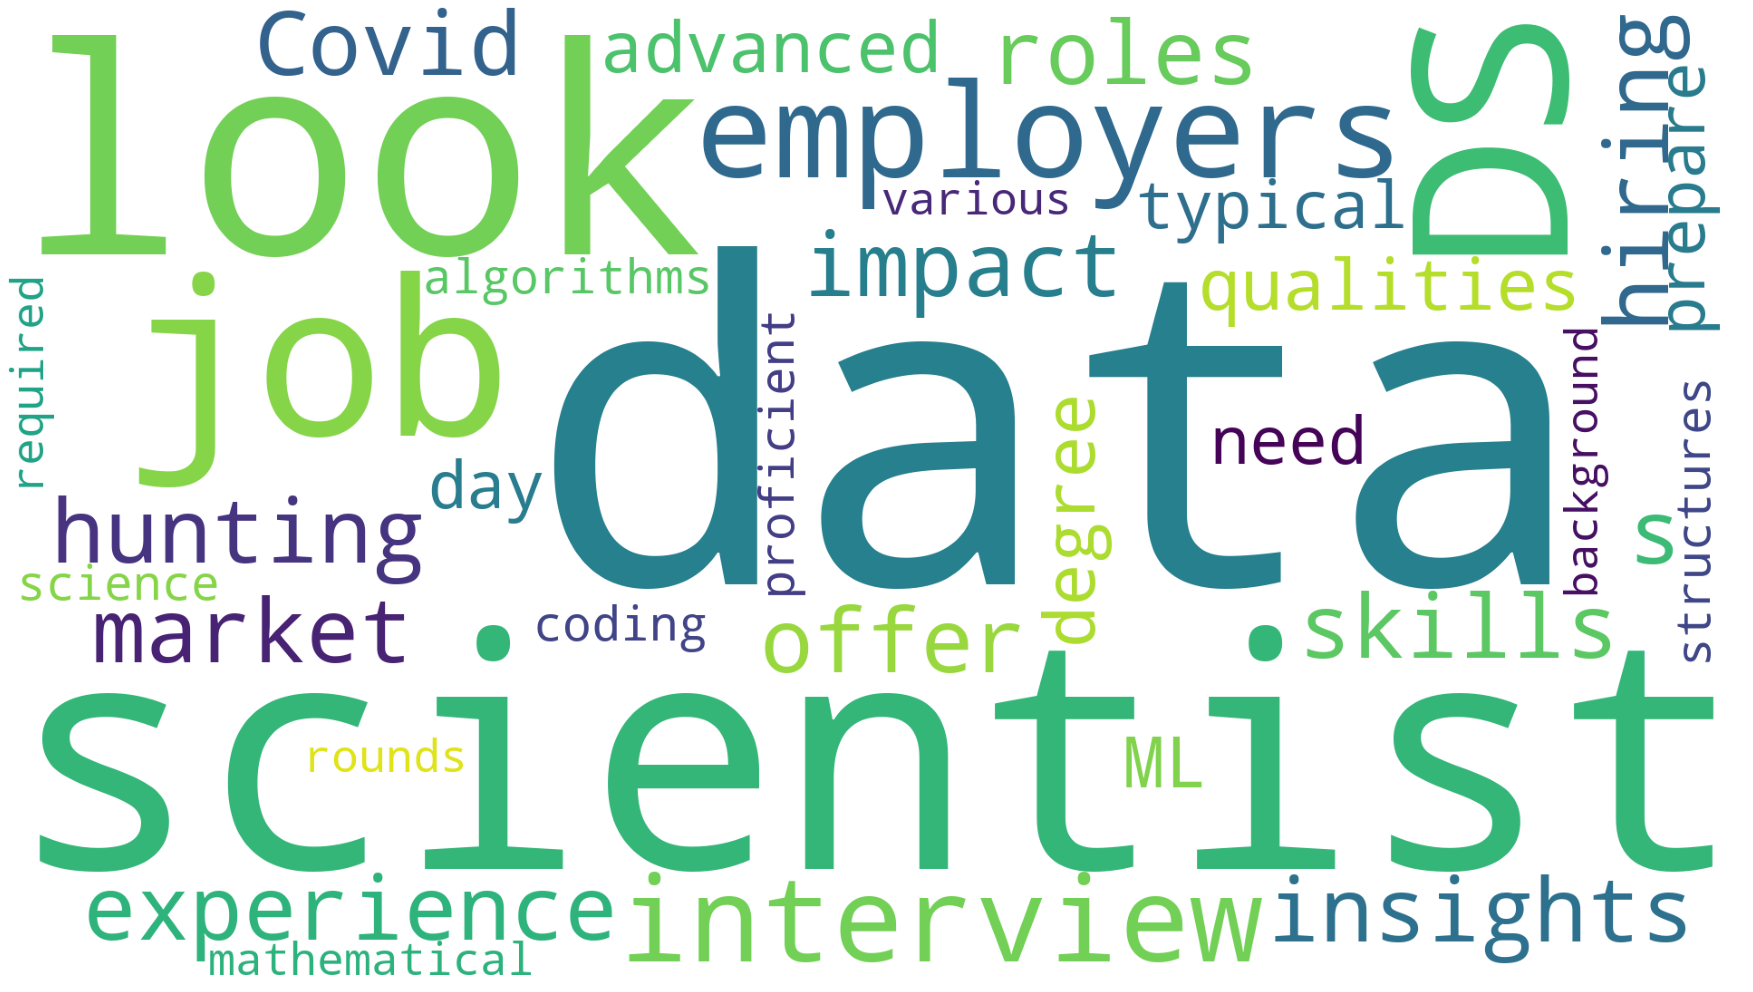

In [8]:
text = ' '.join(df.questions)
cloud = WordCloud(background_color='white', width=1920, height=1080).generate(text)
plt.figure(figsize=(32, 18))
plt.axis('off')
plt.imshow(cloud)
plt.savefig('questions_wordcloud.png')

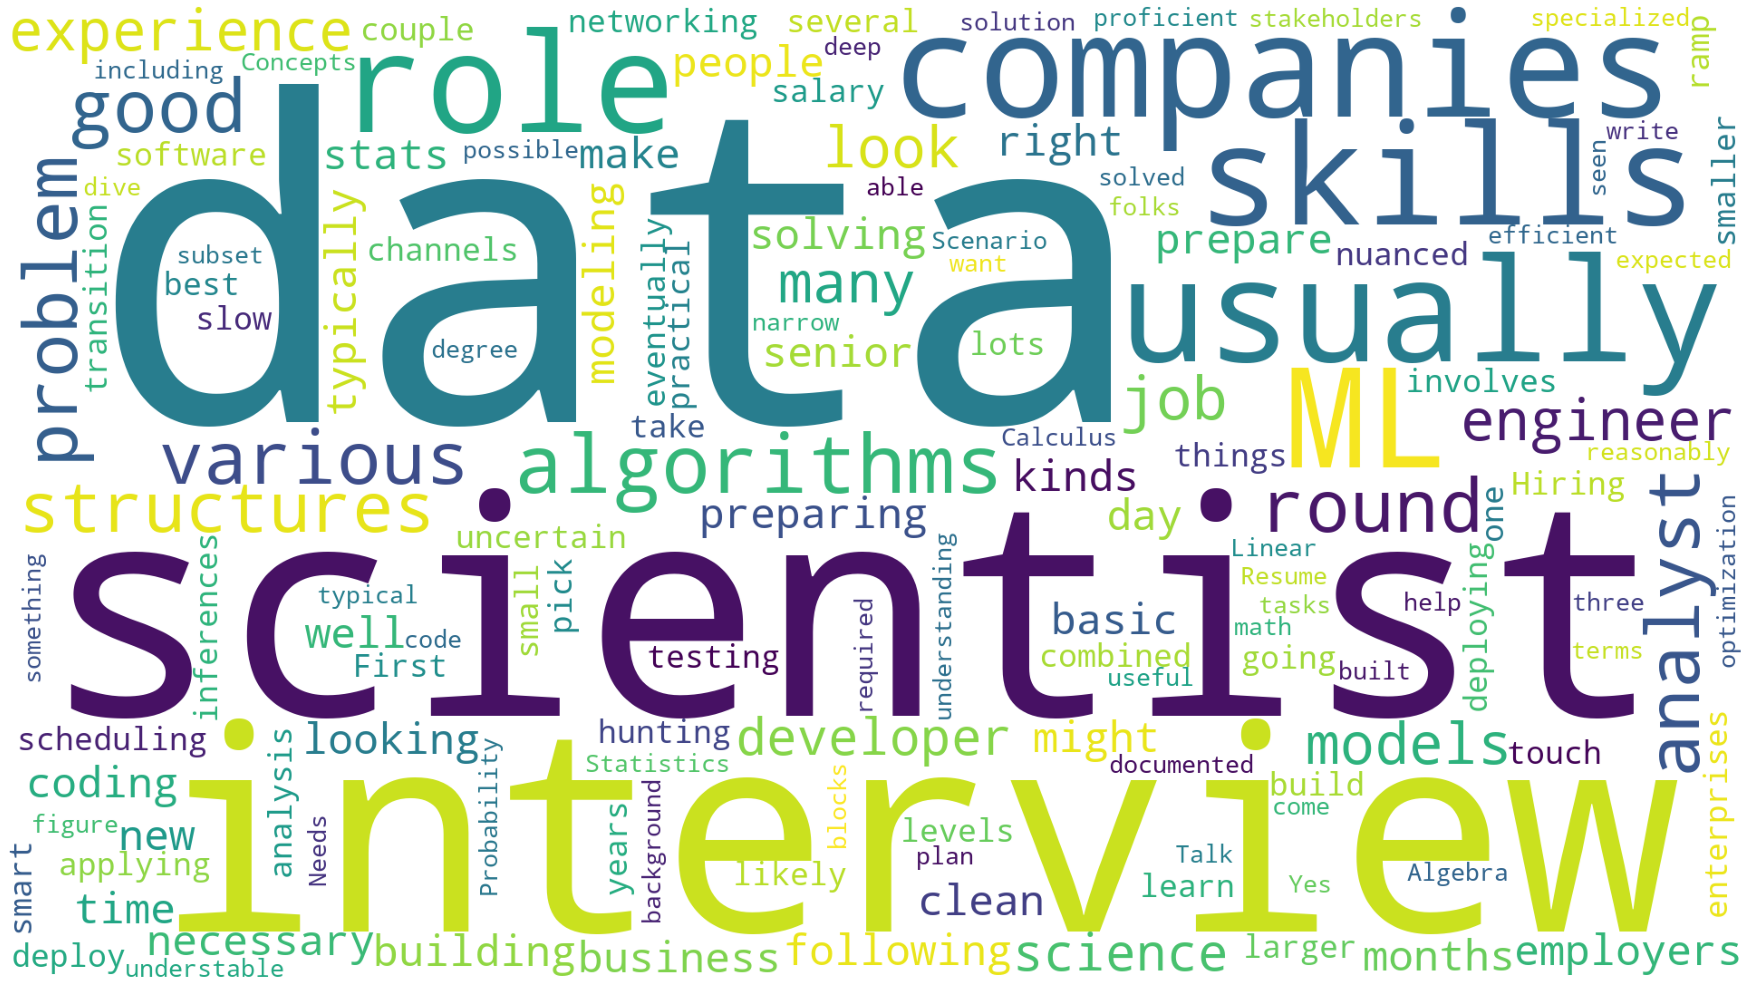

In [9]:
text = ' '.join(df.answers)
cloud = WordCloud(background_color='white', width=1920, height=1080).generate(text)
plt.figure(figsize=(32, 18))
plt.axis('off')
plt.imshow(cloud)
plt.savefig('questions_wordcloud.png')

In [10]:
import re
import gensim 
from gensim.parsing.preprocessing import remove_stopwords
def clean_sentence(sentence, stopwords=False):   
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)
    
    if stopwords:
         sentence = remove_stopwords(sentence)
    return sentence

def get_cleaned_sentences(df,stopwords=False):    
    sents=df[["questions"]];
    cleaned_sentences=[]

    for index,row in df.iterrows():
        cleaned=clean_sentence(row["questions"],stopwords);
        cleaned_sentences.append(cleaned);
    return cleaned_sentences;

cleaned_sentences_without_stopwords = get_cleaned_sentences(df,stopwords=True)
cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)

In [11]:
import nltk 

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\atulmaniraj15\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stopwords_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def my_tokenizer(doc):
    words = word_tokenize(doc)    
    pos_tags = pos_tag(words)
    non_stopwords = [w for w in pos_tags if not w[0].lower() in stopwords_list]
    non_punctuation = [w for w in non_stopwords if not w[0] in string.punctuation]
    lemmas = []
    for w in non_punctuation:
        if w[1].startswith('J'):
            pos = wordnet.ADJ
        elif w[1].startswith('V'):
            pos = wordnet.VERB
        elif w[1].startswith('N'):
            pos = wordnet.NOUN
        elif w[1].startswith('R'):
             pos = wordnet.ADV
        else:
            pos = wordnet.NOUN
        lemmas.append(lemmatizer.lemmatize(w[0], pos))
    return lemmas

In [14]:
def getWordVec(word,model):
        samp=model['computer'];
        vec=[0]*len(samp);
        try:
                vec=model[word];
        except:
                vec=[0]*len(samp);
        return (vec)

def getPhraseEmbedding(phrase,embeddingmodel):                    
        samp=getWordVec('computer', embeddingmodel);
        vec=np.array([0]*len(samp));
        den=0;
        for word in phrase.split():
            den=den+1;
            vec=vec+np.array(getWordVec(word,embeddingmodel));
        return vec.reshape(1, -1)

# Bag of Word

In [15]:
from gensim import corpora
import pprint

sentence_words = [[word for word in document.split() ]
         for document in cleaned_sentences_with_stopwords]

dictionary = corpora.Dictionary(sentence_words)
#for key, value in dictionary.items():
    #print(key, ' : ', value)

bow_corpus = [dictionary.doc2bow(text) for text in sentence_words]
#for sent,embedding in zip(sentences,bow_corpus):
 #   print(sent)
  #  print(embedding)

In [16]:
def ask_question_bow(question):
    question=clean_sentence(question,stopwords=False);
    question_embedding = dictionary.doc2bow(question.split())
    
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(bow_corpus):
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
        if sim>max_sim:
            max_sim=sim;
            index_sim=index;
    print("*****BAG OF WORDS MODEL*****\n")
    print('Your question:\t\t', question)
    print('Closest question found:\t', df['questions'].iloc[index_sim])
    print("\n")
    print('Cosine Similarity: {:.2%}'.format(max_sim))
    print("\n")
    print('Answer:', df.iloc[index_sim]['answers'])

In [17]:
ask_question_bow('what does a data scientist usually do ?')

*****BAG OF WORDS MODEL*****

Your question:		 what does a data scientist usually do 
Closest question found:	 What does the job hunting experience look like ?


Cosine Similarity: 100.00%


Answer: Job hunting experience involves networking to get in touch with the right people in various companies, applying to lots of jobs through various channels, preparing for interviews – while interviews are uncertain it is necessary to prepare well what you CAN prepare, smart scheduling of interviews to get the best job and salary you can. 


# Word2Vec Model

In [18]:
from gensim.models import Word2Vec 
import gensim.downloader as api

v2w_model=None;
try:
    v2w_model = gensim.models.KeyedVectors.load("./w2vecmodel.mod")
    print("Loaded w2v model")
except:            
    v2w_model = api.load('word2vec-google-news-300')
    v2w_model.save("./w2vecmodel.mod")
    print("Saved glove model")

w2vec_embedding_size=len(v2w_model['computer']);

Loaded w2v model


In [19]:
def ask_question_w2v(question):
    sent_embeddings=[];
    for sent in cleaned_sentences_with_stopwords:
        sent_embeddings.append(getPhraseEmbedding(sent,v2w_model));

    question_embedding=getPhraseEmbedding(question,v2w_model);
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sent_embeddings):
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
        if sim>max_sim:
            max_sim=sim;
            index_sim=index;
            
    print("*****WORD2VEC MODEL*****\n")
    print('Your question:\t\t', question)
    print('Closest question found:\t', df['questions'].iloc[index_sim])
    print("\n")
    print('Cosine Similarity: {:.2%}'.format(max_sim))
    print("\n")
    print('Answer:', df.iloc[index_sim]['answers'])

In [20]:
ask_question_w2v('what does a data scientist usually do?')

*****WORD2VEC MODEL*****

Your question:		 what does a data scientist usually do?
Closest question found:	 How does a typical day of a data scientist look like?


Cosine Similarity: 85.97%


Answer: Here are some tasks in the typical day of a data scientist: (1)Make a plan for the day .(2)Look at data, what clean up is required, figure out what models can be built .(3)Talk to various stakeholders about what modeling is possible and help them narrow down to something useful for the business


# Glove Model

In [21]:
glove_model=None;
try:
    glove_model = gensim.models.KeyedVectors.load("./glovemodel.mod")
    print("Loaded glove model")
except:            
    glove_model = api.load('glove-twitter-25')
    glove_model.save("./glovemodel.mod")
    print("Saved glove model")   
glove_embedding_size=len(glove_model['computer']);

Loaded glove model


In [22]:
def ask_question_glove(question):
    sent_embeddings=[];
    for sent in cleaned_sentences_with_stopwords:
        sent_embeddings.append(getPhraseEmbedding(sent,glove_model));
    question_embedding=getPhraseEmbedding(question,glove_model);
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sent_embeddings):
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
        if sim>max_sim:
            max_sim=sim;
            index_sim=index;
            
    print("*****GLOVE MODEL*****\n")
    print('Your question:\t\t', question)
    print('Closest question found:\t', df['questions'].iloc[index_sim])
    print("\n")
    print('Cosine Similarity: {:.2%}'.format(max_sim))
    print("\n")
    print('Answer:', df.iloc[index_sim]['answers'])

In [23]:
ask_question_glove('what does a data scientist usually do ?')

*****GLOVE MODEL*****

Your question:		 what does a data scientist usually do ?
Closest question found:	 How does a typical day of a data scientist look like?


Cosine Similarity: 97.33%


Answer: Here are some tasks in the typical day of a data scientist: (1)Make a plan for the day .(2)Look at data, what clean up is required, figure out what models can be built .(3)Talk to various stakeholders about what modeling is possible and help them narrow down to something useful for the business


# TF-IDF Model

In [24]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\atulmaniraj15\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\atulmaniraj15\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\atulmaniraj15\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [26]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=my_tokenizer)
tfidf_matrix = tfidf_vectorizer.fit_transform(tuple(df['questions']))

In [27]:
def ask_question_tfidf(question):
    query_vect = tfidf_vectorizer.transform([question])
    similarity = cosine_similarity(query_vect, tfidf_matrix)
    max_similarity = np.argmax(similarity, axis=None)
    
    print("*****TF-IDF MODEL*****\n")
    print('Your question:\t\t', question)
    print('Closest question found:\t', df.iloc[max_similarity]['questions'])
    print("\n")
    print('Cosine Similarity: {:.2%}'.format(similarity[0, max_similarity]))
    print("\n")
    print('Answer:', df.iloc[max_similarity]['answers'])

In [28]:
ask_question_tfidf('what does a data scientist usually do ?')

*****TF-IDF MODEL*****

Your question:		 what does a data scientist usually do ?
Closest question found:	 How proficient should a data scientist be in coding? 


Cosine Similarity: 49.26%


Answer: Needs to be reasonably proficient. Again, a data scientist is a developer ++. Usually expected to have the basic skills a developer has including understanding algorithms and data structures and being able to write clean, understable, efficient, well documented code. 


# BERT Model

# Why Bert Embedding?
In this tutorial, we will use BERT to extract features, namely word and sentence embedding vectors, from text data. What can we do with these word and sentence embedding vectors? First, these embeddings are useful for keyword/search expansion, semantic search and information retrieval. For example, if you want to match customer questions or searches against already answered questions or well documented searches, these representations will help you accuratley retrieve results matching the customer’s intent and contextual meaning, even if there’s no keyword or phrase overlap.

In [29]:
pip install bert-serving-server

In [30]:
pip install bert-serving-client

Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install transformers

In [32]:
pip install -U bert-serving-server bert-serving-client

In [33]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install simpletransformers

In [38]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
bert-serving-start -model_dir /bert_model.ckpt.index/  -num_worker=1

SyntaxError: cannot assign to operator (<ipython-input-10-d6f420bcbe2c>, line 1)

In [ ]:
from bert_serving.client import BertClient
bc = BertClient(check_length=False)
res=bc.encode(['ML', 'AI'])

In [ ]:
def ask_question_bert(question):
    #question = clean_sentence(question,stopwords=False);

    sent_bertphrase_embeddings=[];
    for sent in cleaned_sentences_with_stopwords:
        sent_bertphrase_embeddings.append(bc.encode([sent]));

    question_embedding=bc.encode([question]);
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sent_bertphrase_embeddings):
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
        if sim>max_sim:
            max_sim=sim;
            index_sim=index;
            
    print("*****BERT MODEL*****\n")
    print('Your question:\t\t', question)
    print('Closest question found:\t', df['questions'].iloc[index_sim])
    print("\n")
    print('Cosine Similarity: {:.2%}'.format(max_sim))
    print("\n")
    print('Answer:', df.iloc[index_sim]['answers'])

In [ ]:
def ask_question(question):
    ask_question_bow(question)
    print("\n--------------------\n")
    ask_question_w2v(question)
    print("\n--------------------\n")
    ask_question_glove(question)
    print("\n--------------------\n")
    ask_question_tfidf(question)
    print("\n--------------------\n")
    #ask_question_bert(question)

In [ ]:
question = "what does a data scientist usually do ?"

ask_question(question)